In [169]:
from typing import Literal, Callable, Any
from math import ceil

import torch
from torch import nn
from torch.utils.data import random_split
from torch.optim import AdamW
import e3nn
from e3nn import o3
from torch_scatter import scatter
from torch_geometric.data import Data as PyGGraph
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_cluster import radius_graph
import pytorch_lightning as pl
from matplotlib import pyplot as plt

from equitriton.sph_harm.direct import triton_spherical_harmonic
from equitriton.utils import spherical_harmonics_irreps

In [5]:
seed = torch.manual_seed(215162)

In [186]:
class AtomEmbedding(nn.Module):
    def __init__(self, num_atoms: int, atom_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_atoms, atom_dim, padding_idx=0)

    def forward(self, atomic_numbers: torch.LongTensor) -> torch.Tensor:
        return self.embedding(atomic_numbers)


class EdgeEmbedding(nn.Module):
    def __init__(self, num_basis: int, radius_cutoff: float = 6.0, **kwargs):
        """
        This module embeds edges in a graph with an EdgeEmbedding object.

        Parameters
        ----------
        num_basis : int, optional
            The number of basis functions. Defaults to 1.
        radius_cutoff : float, optional
            The maximum radius up to which basis functions are defined. Defaults to 6.0.

        Optional kwargs
        ---------------
        basis : str, optional
            The type of basis function to use. Defaults to 'bessel'.
        start : float, optional
            The starting point in the distance grid used in the radial basis.
        cutoff : bool, optional
            Whether or not to apply a cutoff to the basis functions.

        Returns
        -------
        torch.Tensor
            A tensor representing the embedding of edges with shape (num_edges, num_basis).

        Examples
        --------
        >>> # Define an instance of EdgeEmbedding with 4 basis functions and a radius cutoff of 10.
        >>> embedder = EdgeEmbedding(num_basis=4, radius_cutoff=10.0)
        """
        super().__init__()
        kwargs.setdefault("basis", "bessel")
        kwargs.setdefault("start", 0.0)
        kwargs.setdefault("cutoff", True)
        self.num_basis = num_basis
        self.radius_cutoff = radius_cutoff
        self.basis_kwargs = kwargs

    def forward(self, distances: torch.Tensor) -> torch.Tensor:
        basis_funcs = e3nn.math.soft_one_hot_linspace(
            distances,
            number=self.num_basis,
            end=self.radius_cutoff,
            **self.basis_kwargs,
        )
        return basis_funcs * self.num_basis**0.5


class SphericalHarmonicEmbedding(nn.Module):
    def __init__(
        self,
        l_values: list[int],
        normalize: bool = True,
        normalization: Literal["norm", "integral", "component"] = "integral",
        use_e3nn: bool = False,
    ):
        """
        Projects cartesian positions onto spherical harmonic functions.
        """
        super().__init__()
        self.l_values = list(sorted(l_values))
        self.irreps = spherical_harmonics_irreps(self.l_values, num_feat=1)
        self.normalize = normalize
        self.normalization = normalization
        self.use_e3nn = use_e3nn

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        if not self.use_e3nn:
            outputs = [triton_spherical_harmonic(l, coords) for l in self.l_values]
            return torch.cat(outputs, dim=-1)
        else:
            return o3.spherical_harmonics(
                self.irreps, coords, self.normalize, self.normalization
            )


class InteractionBlock(nn.Module):
    def __init__(
        self,
        atomic_dim: int | o3.Irreps,
        l_values: int,
        edge_dim: int,
        hidden_dim: int,
        radius_cutoff: float,
        degree_norm: float,
        edge_kwargs: dict[str, Any] = {},
        sph_harm_kwargs: dict[str, Any] = {},
        activation: Callable = nn.functional.silu,
    ):
        """
        A module that combines radial basis with spherical harmonics to
        describe molecular interactions.

        Parameters
        ----------
        atomic_dim : int | o3.Irreps
            Dimension of the atomic features. If int, it is treated as a
            single irreducible representation.
        l_values : int
            Values of the spherical harmonic order.
        edge_dim : int
            Dimension of the edge features.
        hidden_dim : int
            Hidden dimension for the fully connected network.
        radius_cutoff : float
            Cutoff radius for the radial basis.
        degree_norm : float
            Normalization factor for the degree of the graph.
        edge_kwargs : dict[str, Any], optional
            Keyword arguments for the EdgeEmbedding module. Defaults to {}.
        sph_harm_kwargs : dict[str, Any], optional
            Keyword arguments for the SphericalHarmonicEmbedding module.
            Defaults to {}.
        activation : Callable, optional
            Activation function for the fully connected network. Defaults to
            nn.functional.silu.

        Notes
        -----
        The `degree_norm` attribute is set as a property and effectively
        represents the average number of neighbors in other models.

        Examples
        --------
        >>> block = InteractionBlock(atomic_dim=8, l_values=[0, 1],
            edge_dim=16, hidden_dim=32)
        >>> block.sph_irreps
        ['1x0e', '2x0e']
        """
        sph_harm_kwargs.setdefault("use_e3nn", False)

        super().__init__()
        # this is effectively the average number of neighbors in other models
        self.degree_norm = degree_norm
        # treat atom features as invariant
        if isinstance(atomic_dim, int):
            atomic_irreps = f"{atomic_dim}x0e"
        else:
            atomic_irreps = atomic_dim
        self.atomic_irreps = atomic_irreps
        self.l_values = list(sorted(l_values))
        # these two attributes are similar but different: the former is used for describing
        # the basis itself, and the latter is for actually specifying the weights
        self.sph_irreps = spherical_harmonics_irreps(self.l_values, num_feat=1)
        self.output_irreps = spherical_harmonics_irreps(
            self.l_values, num_feat=hidden_dim
        )
        # tensor product is the final bit the combines the radial basis with the spherical
        # harmonics
        self.tensor_product = o3.FullyConnectedTensorProduct(
            self.atomic_irreps,
            self.sph_irreps,
            self.output_irreps,
            shared_weights=False,
        )
        self.edge_basis = EdgeEmbedding(edge_dim, radius_cutoff, **edge_kwargs)
        self.spherical_harmonics = SphericalHarmonicEmbedding(
            l_values, **sph_harm_kwargs
        )
        self.fc = e3nn.nn.FullyConnectedNet(
            [edge_dim, hidden_dim, self.tensor_product.weight_numel], activation
        )

    @property
    def num_projections(self) -> int:
        """Returns the expected number of projections."""
        return sum([2 * l + 1 for l in self.l_values])

    @property
    def output_dim(self) -> int:
        """Returns the dimensionality of the output."""
        return self.output_irreps.dim

    def forward(
        self,
        atomic_features: torch.Tensor,
        coords: torch.Tensor,
        edge_index: torch.LongTensor,
    ) -> torch.Tensor:
        """
        High-level description:

        1. Project cartesian coordinates onto spherical harmonic basis
        2. Project interatomic distances onto radial (bessel) basis
        3. Transform radial basis functions with learnable weights
        4. Compute tensor product between scalar atom features and spherical harmonic basis
        5. Update node features
        """
        edge_dist = coords[edge_index[0]] - coords[edge_index[1]]
        sph_harm = self.spherical_harmonics(edge_dist)
        # calculate atomic distances, embed, and transform them
        edge_basis = self.edge_basis(edge_dist.norm(dim=-1))
        edge_z = self.fc(edge_basis)
        # compute tensor product
        messages = self.tensor_product(atomic_features[edge_index[0]], sph_harm, edge_z)
        # update node features
        hidden_feats = (
            scatter(messages, edge_index[1], dim=0, dim_size=atomic_features.size(0))
            / self.degree_norm
        )
        return hidden_feats


class ScalarReadoutLayer(nn.Module):
    def __init__(self, hidden_irreps: o3.Irreps, output_dim: int):
        super().__init__()
        self.hidden_irreps = hidden_irreps
        self.output_irreps = o3.Irreps(f"{output_dim}x0e")
        self.output_layer = o3.Linear(
            irreps_in=hidden_irreps, irreps_out=self.output_irreps
        )

    def forward(self, node_feats: torch.Tensor) -> torch.Tensor:
        return self.output_layer(node_feats)


class EquiTritonModel(nn.Module):
    def __init__(
        self,
        initial_atom_dim: int,
        num_layers: int,
        output_dim: int,
        l_values: int,
        edge_dim: int,
        hidden_dim: int,
        radius_cutoff: float,
        degree_norm: float,
        edge_kwargs: dict[str, Any] = {},
        sph_harm_kwargs: dict[str, Any] = {},
        activation: Callable = nn.functional.silu,
        num_atoms: int = 100,
        skip_connections: bool = True,
    ):
        """
        A neural network model designed for processing molecular graphs.

        This class implements a hierarchical architecture with multiple interaction blocks,
        allowing for efficient and scalable processing of large molecular datasets.

        Parameters:
            initial_atom_dim (int): The dimensionality of the atomic embeddings.
            num_layers (int): The number of convolutional layers to use.
            output_dim (int): The dimensionality of the final scalar features.
            l_values (int): A list of spherical harmonics order to consider.
            edge_dim (int): The dimensionality of the edge features.
            hidden_dim (int): The dimensionality of the hidden state in each interaction block.
            radius_cutoff (float): The cutoff distance for radial basis functions.
            degree_norm (float): The normalization constant for edge features. Typically square root of the average degree.
            edge_kwargs (dict[str, Any], optional): Keyword arguments to pass to the InteractionBlock. Defaults to {}.
            sph_harm_kwargs (dict[str, Any], optional): Keyword arguments to pass to the InteractionBlock. Defaults to {}.
            activation (Callable, optional): The activation function to use in each interaction block. Defaults to nn.functional.silu.
            num_atoms (int, optional): The number of atoms in the embedding table (i.e. unique elements). Defaults to 100.
            skip_connections (bool, optional): Whether to enable residual connections between layers. Defaults to True.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the graph-level scalar features and the node features.

        Examples:
            >>> model = EquiTritonModel(...)
            >>> graph = PyGGraph(...).to(device="cuda")
            >>> graph_z, z = model(graph)

        Note: This class uses PyTorch Geometric's Graph data structure and assumes that the input graph has already been processed using a suitable preprocessing step.
        """
        sph_harm_kwargs.setdefault("use_e3nn", False)

        super().__init__()
        self.atomic_embedding = AtomEmbedding(num_atoms, initial_atom_dim)
        self.initial_layer = InteractionBlock(
            initial_atom_dim,
            l_values,
            edge_dim,
            hidden_dim,
            radius_cutoff,
            degree_norm,
            edge_kwargs,
            sph_harm_kwargs,
            activation,
        )
        self.conv_layers = nn.ModuleDict()
        for layer_index in range(num_layers + 1):
            self.conv_layers[f"conv_{layer_index}"] = InteractionBlock(
                self.initial_layer.output_dim,
                l_values,
                edge_dim,
                hidden_dim,
                radius_cutoff,
                degree_norm,
                edge_kwargs,
                sph_harm_kwargs,
                activation,
            )
        self.scalar_readout = ScalarReadoutLayer(
            self.initial_layer.output_irreps, output_dim
        )
        self.skip_connections = skip_connections
        self.output_dim = output_dim

    def visualize(self, **kwargs):
        num_plots = len(self.conv_layers) + 1
        fig, axarray = plt.subplots(num_plots, 1, figsize=(3, 12))
        # make indexing easier
        axarray = axarray.flatten()

        self.initial_layer.tensor_product.visualize(ax=axarray[0], **kwargs)
        axarray[0].set_title("Input layer", loc="right")
        index = 1
        for layer_name, layer in self.conv_layers.items():
            ax = axarray[index]
            layer.tensor_product.visualize(ax=ax, **kwargs)
            ax.set_title(layer_name, loc="right")
            index += 1
        fig.tight_layout()
        return fig, axarray

    def forward(self, graph: PyGGraph) -> tuple[torch.Tensor, torch.Tensor]:
        # determine if the graph is batched or not
        is_batched = hasattr(graph, "ptr")
        # get atom embeddings
        atom_z = self.atomic_embedding(graph.z)  # [nodes, initial_atom_dim]
        # first message passing step
        z = self.initial_layer(atom_z, graph.pos, graph.edge_index)
        outputs = {}
        for layer_name, layer in self.conv_layers.items():
            new_z = layer(z, graph.pos, graph.edge_index)
            # add residual connections
            if self.skip_connections and new_z.shape == z.shape:
                new_z += z
            z = new_z
            outputs[layer_name] = z
        # map final output as scalars
        z = self.scalar_readout(z)
        # latest node features are in z; we generate graph-level scalar features
        # by doing a scatter add
        if is_batched:
            graph_z = scatter(z, graph.batch, dim=0, dim_size=graph.batch_size)
        else:
            # for a single graph, just sum up the node features
            graph_z = z.sum(dim=0, keepdims=True)
        return graph_z, z

In [144]:
def make_fake_graph(
    num_nodes: int,
    num_edges: int,
    max_radius: float = 1.5,
    coord_scale: float = 1.0,
    max_atomic_number: int = 100,
    device="cuda",
):
    coords = torch.rand(num_nodes, 3, device=device) * coord_scale
    edge_src, edge_dst = radius_graph(
        coords, max_radius, max_num_neighbors=num_nodes - 1
    )
    edge_index = torch.vstack([edge_src, edge_dst]).to(device)
    atomic_numbers = torch.randint(
        0, max_atomic_number, size=(num_nodes,), device=device
    )
    return coords, edge_index, atomic_numbers

In [145]:
edge_embedder = EdgeEmbedding(num_basis=10)

In [146]:
coords, edge_index, atomic_numbers = make_fake_graph(
    16,
    12,
)

In [147]:
# coords = torch.ones_like(coords, requires_grad=True)

In [148]:
atom_embedder = AtomEmbedding(100, 64).to("cuda")
atom_z = atom_embedder(atomic_numbers)

In [149]:
edge_index.shape

torch.Size([2, 240])

In [151]:
layer = InteractionBlock(
    64,
    [
        0,
        1,
        2,
    ],
    10,
    32,
    radius_cutoff=6.0,
    degree_norm=17**0.5,
    sph_harm_kwargs={"use_e3nn": True},
).to("cuda")

/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [132]:
next_layer = InteractionBlock(
    layer.output_irreps,
    [
        0,
        1,
        2,
    ],
    10,
    32,
    radius_cutoff=6.0,
    degree_norm=17**0.5,
).to("cuda")

/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [152]:
layer

InteractionBlock(
  (tensor_product): FullyConnectedTensorProduct(64x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 6144 paths | 6144 weights)
  (edge_basis): EdgeEmbedding()
  (spherical_harmonics): SphericalHarmonicEmbedding()
  (fc): FullyConnectedNet[10, 32, 6144]
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

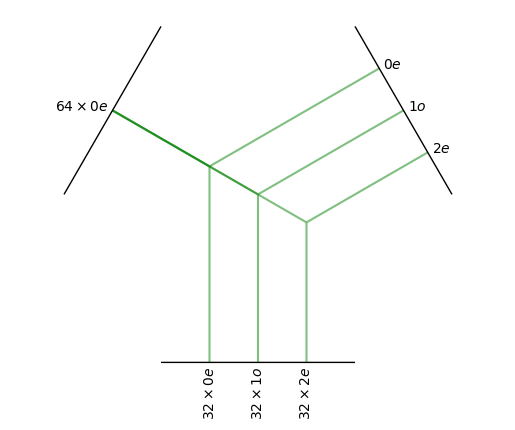

In [153]:
layer.tensor_product.visualize()

In [154]:
o = layer(atom_z, coords, edge_index)

In [155]:
o

tensor([[ 0.0590, -1.6986, -0.3744,  ..., -2.5936, -2.0722,  1.8019],
        [-1.0968, -2.7137, -2.4289,  ...,  1.1375,  0.9818,  0.9651],
        [-0.4404, -2.5330, -1.6619,  ...,  0.1385,  2.5301,  0.2258],
        ...,
        [-0.1863, -0.3904,  0.2787,  ...,  0.0165, -0.0322,  0.7170],
        [ 0.5232, -1.4793, -0.0937,  ..., -1.7656,  0.8989,  0.3833],
        [-0.1590, -1.6844,  0.0832,  ..., -1.7279,  0.9028, -0.9102]],
       device='cuda:0', grad_fn=<DivBackward0>)

## Equivariance check

Uses `e3nn` tooling to generate the random rotation matrix, and output as a function of rotation permutation: rotating the coordinates before passing into the layer, and rotating the transformed embeddings with the same rotation matrix.

In [192]:
# [0, 1, 2] are necessary at the minimum, but all orders should work
layer = InteractionBlock(
    64,
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    10,
    32,
    radius_cutoff=6.0,
    degree_norm=17**0.5,
    sph_harm_kwargs={"use_e3nn": True},
).to("cuda")

/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [193]:
rot_matrix = o3.rand_matrix()

# dims_in doesn't actually do anything in the case where the features are scalar
dims_in = o3.Irreps(layer.atomic_irreps).D_from_matrix(rot_matrix).to("cuda")
# but dims_out actually does something, since the output features/embeddings need
# to be rotated based on the same rotation matrix
dims_out = layer.output_irreps.D_from_matrix(rot_matrix).to("cuda")

# rotate coordinates before passing into the layer
rot_before = layer(atom_z @ dims_in.T, coords @ rot_matrix.T.to("cuda"), edge_index)
# rotate layer output by the same rotation matrix
rot_after = layer(atom_z, coords, edge_index) @ dims_out.T

assert torch.allclose(rot_before, rot_after, rtol=1e-7, atol=1e-4)

### Rotation + translation

If all atoms are shifted by a vector, the Bessel embedding should also be the same as it works solely on interatom distances.

The output shouldn't need to be shifted.

In [189]:
rot_matrix = o3.rand_matrix()
# shift all coordinates by the same amount in space
trans_matrix = torch.randn(size=(1, 3), device="cuda")

# dims_in doesn't actually do anything in the case where the features are scalar
dims_in = o3.Irreps(layer.atomic_irreps).D_from_matrix(rot_matrix).to("cuda")
dims_out = layer.output_irreps.D_from_matrix(rot_matrix).to("cuda")

# rotate and translate coordinates before passing into the layer
rot_before = layer(
    atom_z @ dims_in.T, coords @ rot_matrix.T.to("cuda") + trans_matrix, edge_index
)
# rotate layer output by the same rotation matrix
rot_after = layer(atom_z, coords, edge_index) @ dims_out.T

assert torch.allclose(rot_before, rot_after, rtol=1e-7, atol=1e-4)

### Mike equivariance check

Need to figure out what is different between these two...

In [183]:
# generate a random rotation matrix (bs, 3, 3)
from scipy.spatial.transform import Rotation

random_rot = torch.tensor(
    Rotation.random(coords.size(0)).as_matrix(), dtype=torch.float32
).to(coords.device)

# random translation (bs, 3)
random_t = torch.rand_like(
    coords
)  # I think it should be a group action, not individual atoms

# rotate coords: (bs, 3, 3) x (bs, 3, 1) -> (bs, 3)
rotated_coords = (random_rot @ coords.unsqueeze(-1)).squeeze(-1)

# o_transl = layer(atom_z, rotated_coords + random_t, edge_index)
og_graph = PyGGraph(pos=coords, z=atomic_numbers, edge_index=edge_index).to("cuda")
rot_graph = PyGGraph(
    pos=coords @ rot_matrix.T.to("cuda"), z=atomic_numbers, edge_index=edge_index
).to("cuda")

model = EquiTritonModel(32, 4, 4, [0, 1, 2], 32, 32, 1.0, 17**0.5).to("cuda")
# o1 = model(og_graph)
# o2 = model(rot_graph)
atom_z = atom_embedder(atomic_numbers)
o1 = layer(atom_z, og_graph.pos, edge_index=og_graph.edge_index)
o2 = layer(atom_z, rot_graph.pos, edge_index=rot_graph.edge_index)

o1, o2

/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute

(tensor([[ 0.0590, -1.6986, -0.3744,  ..., -2.5936, -2.0722,  1.8019],
         [-1.0968, -2.7137, -2.4289,  ...,  1.1375,  0.9818,  0.9651],
         [-0.4404, -2.5330, -1.6619,  ...,  0.1385,  2.5301,  0.2258],
         ...,
         [-0.1863, -0.3904,  0.2787,  ...,  0.0165, -0.0322,  0.7170],
         [ 0.5232, -1.4793, -0.0937,  ..., -1.7656,  0.8989,  0.3833],
         [-0.1590, -1.6844,  0.0832,  ..., -1.7279,  0.9028, -0.9102]],
        device='cuda:0', grad_fn=<DivBackward0>),
 tensor([[ 0.0590, -1.6986, -0.3744,  ...,  2.6008,  0.3975, -1.8447],
         [-1.0968, -2.7137, -2.4289,  ..., -0.2491, -1.0484,  1.2295],
         [-0.4404, -2.5330, -1.6619,  ..., -2.0959, -2.8912, -0.1732],
         ...,
         [-0.1863, -0.3904,  0.2787,  ...,  0.5650, -0.1882,  0.3297],
         [ 0.5232, -1.4793, -0.0937,  ...,  1.1183, -1.3011, -0.5838],
         [-0.1590, -1.6844,  0.0832,  ...,  0.1020, -0.7125, -0.9762]],
        device='cuda:0', grad_fn=<DivBackward0>))

(<Figure size 300x1200 with 6 Axes>,
 array([<Axes: title={'right': 'Input layer'}>,
        <Axes: title={'right': 'conv_0'}>,
        <Axes: title={'right': 'conv_1'}>,
        <Axes: title={'right': 'conv_2'}>,
        <Axes: title={'right': 'conv_3'}>,
        <Axes: title={'right': 'conv_4'}>], dtype=object))

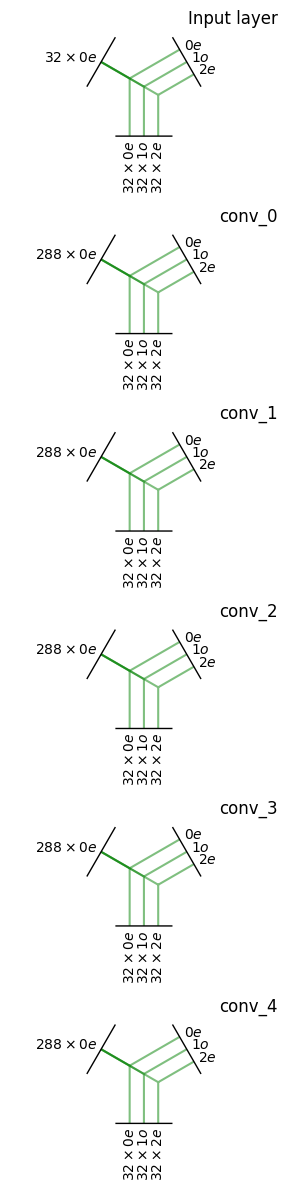

In [184]:
model.visualize()

In [165]:
tests = []
for axis in range(o1.size(-1)):
    tests.append(torch.allclose(o1[:, axis], o2[:, axis], rtol=1e-7, atol=1e-4))

In [ ]:
p = next_layer(o, coords, edge_index)

In [15]:
o.shape

torch.Size([16, 1024])

In [ ]:
o + p

## Dataset definition

In [30]:
class LightningQM9(pl.LightningDataModule):
    def __init__(
        self,
        root_path: str = "./qm9_data",
        batch_size: int = 16,
        train_frac: float = 0.8,
        val_frac: float = 0.1,
        num_workers: int = 0,
    ):
        """
        Custom data module for QM9 dataset.

        Parameters
        ----------
        root_path : str, optional (default: "./qm9_data")
            Path to the QM9 dataset.
        batch_size : int, optional (default: 16)
            Number of samples in each mini-batch.
        train_frac : float, optional (default: 0.8)
            Fraction of data used for training.
        val_frac : float, optional (default: 0.1)
            Fraction of data used for validation.
        num_workers : int, optional (default: 0)
            Number of worker processes to use for loading data.

        Examples
        --------
        >>> dm = LightningQM9(root_path="/path/to/qm9_data", batch_size=32)

        Attributes
        ----------
        dataset : QM9
            Loaded QM9 dataset.
        hparams : dict
            Hyperparameters of the data module.

        Methods
        -------
        setup(stage: str)
            Setup data splits for training, validation and testing.
        train_dataloader()
            Returns a DataLoader instance for training data.
        val_dataloader()
            Returns a DataLoader instance for validation data.
        test_dataloader()
            Returns a DataLoader instance for testing data.
        """
        super().__init__()
        self.dataset = QM9(root_path)
        self.save_hyperparameters()

    def setup(self, stage: str):
        hparams = self.hparams
        num_samples = len(self.dataset)
        num_train = int(num_samples * hparams["train_frac"])
        num_val = int(num_samples * hparams["val_frac"])
        num_test = ceil(
            num_samples * (1 - (hparams["train_frac"] + hparams["val_frac"]))
        )
        # generate random splits
        train_split, val_split, test_split = random_split(
            self.dataset, lengths=[num_train, num_val, num_test]
        )
        self.splits = {"train": train_split, "val": val_split, "test": test_split}

    def train_dataloader(self):
        return DataLoader(
            self.splits["train"],
            batch_size=self.hparams["batch_size"],
            shuffle=True,
            num_workers=self.hparams["num_workers"],
        )

    def val_dataloader(self):
        return DataLoader(
            self.splits["val"],
            batch_size=self.hparams["batch_size"],
            shuffle=False,
            num_workers=self.hparams["num_workers"],
        )

    def test_dataloader(self):
        return DataLoader(
            self.splits["test"],
            batch_size=self.hparams["batch_size"],
            shuffle=False,
            num_workers=self.hparams["num_workers"],
        )

## Loss and Lightning module

Model trains optionally with a loss target that Nequip and MACE uses, which is the atom-weighted MSE. For now we're only using a single target, but can expand to use the full QM9 set of targets too.

In [31]:
class AtomWeightedMSE(nn.Module):
    """
    Calculates the mean-squared-error between predicted and targets,
    weighted by the number of atoms within each graph.

    From matsciml
    """

    def forward(
        self,
        input: torch.Tensor,
        target: torch.Tensor,
        atoms_per_graph: torch.Tensor,
    ) -> torch.Tensor:
        if atoms_per_graph.size(0) != target.size(0):
            raise RuntimeError(
                "Dimensions for atom-weighted loss do not match:"
                f" expected atoms_per_graph to have {target.size(0)} elements; got {atoms_per_graph.size(0)}."
                "This loss is intended to be applied to scalar targets only."
            )
        # check to make sure we are broad casting correctly
        if (input.ndim != target.ndim) and target.size(-1) == 1:
            input.unsqueeze_(-1)
        # for N-d targets, we might want to keep unsqueezing
        while atoms_per_graph.ndim < target.ndim:
            atoms_per_graph.unsqueeze_(-1)
        # ensures that atoms_per_graph is type cast correctly
        squared_error = ((input - target) / atoms_per_graph.to(input.dtype)) ** 2.0
        return squared_error.mean()


class EquiTritonLitModule(pl.LightningModule):
    def __init__(
        self,
        model_class: type,
        model_kwargs,
        e_mean: float,
        e_std: float,
        lr: float = 1e-3,
        weight_decay: float = 0.0,
        atom_weighted_loss: bool = True,
    ):
        """
        Initializes the EquiTritonLitModule clas.

        Parameters
        ----------
        model_class : type
            Th class of the model to be used.
        model_kwargs : dict
            Keyword argument for the model initialization.
        e_mean : float
            The mean of the energy values.
        e_std : float
            The standard deviation of the energy values.
        lr : float, optional
            The learning rate (default is 1e-3) for AdamW.
        weight_decay : float, optional
            Weight decay value (default is 0.0).
        atom_weighted_loss : bool, optional
            Whether to use atom-weighted loss or not (default is True).
        """
        super().__init__()
        self.model = model_class(**model_kwargs)
        if atom_weighted_loss:
            self.loss = AtomWeightedMSE()
        else:
            self.loss = nn.MSELoss()
        self.output_head = nn.Linear(self.model.output_dim, 1)
        self.save_hyperparameters()

    def configure_optimizers(self):
        return AdamW(
            self.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams["weight_decay"],
        )

    def step(self, graph: PyGGraph, stage: Literal["train", "test", "val"]):
        """
        Performs a single step of the training, validation or testing
        process.

        Parameters
        ----------
        graph : PyGGraph
            The input graph.
        stage : Literal["train", "test", "val"]
            The current stage (training, testing or validation).

        Returns
        -------
        loss : float
            The calculated loss value.
        """
        g_z, z = self.model(graph)
        pred_energy = self.output_head(g_z)
        target_energy = graph.y[:, 12].unsqueeze(-1)
        norm_energy = (target_energy - self.hparams["e_mean"]) / self.hparams["e_std"]
        if self.hparams["atom_weighted_loss"]:
            loss = self.loss(pred_energy, norm_energy, torch.diff(graph.ptr))
        else:
            loss = self.loss(pred_energy, norm_energy)
        batch_size = getattr(graph, "batch_size", 1)
        self.log(
            f"{stage}_loss", loss, prog_bar=True, on_step=True, batch_size=batch_size
        )
        return loss

    def training_step(self, batch):
        loss = self.step(batch, "train")
        return loss

    def validation_step(self, batch):
        loss = self.step(batch, "val")
        return loss

    def test_step(self, batch):
        loss = self.step(batch, "test")
        return loss

In [32]:
dm = LightningQM9("./qm9_data/", batch_size=64)
dm.setup("fit")

train_loader = dm.train_dataloader()

/home/kelvin/miniforge3/envs/equitriton/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and 

In [33]:
values = torch.cat([sample.y[:, 12] for sample in dm.dataset])
e_mean = values.mean()
e_std = values.std()

In [ ]:
lit_mod = EquiTritonLitModule(
    EquiTritonModel,
    model_kwargs={
        "initial_atom_dim": 64,
        "num_layers": 3,
        "output_dim": 48,
        "l_values": [0, 1, 2, 4, 6, 8],
        "edge_dim": 10,
        "hidden_dim": 16,
        "radius_cutoff": 6.0,
        "degree_norm": 37.5**0.5,
    },
    e_mean=e_mean,
    e_std=e_std,
    atom_weighted_loss=False,
)

In [ ]:
trainer = pl.Trainer(max_epochs=30, accelerator="gpu")

In [ ]:
trainer.fit(lit_mod, datamodule=dm)